# 02806 Social data analysis and visualization
# Project Assignment B
# Living Conditions in Denmark

## Motivation

### We have found a data set containing the living conditions of families in Denmark. The data set i divided in districts, type of resident, type of dwelling, heating, toiletfacilities, bathfacilities, type of household and number of childrens through the years of 2010-2016

### We have chosen to use this dataset because we both live in Denmark, and are intrigued that there might still be places in Denmark where there is children living and they dont have acces to either bath or toilet.

### We want to show the progress of living standards in Denmark, and how it have changed through the years.

In [1]:
# imports
from __future__ import division
import csv
import json
import time
timeNow=time.time()
import random
import numpy as np
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
# load data into dictionarie
socStatus = []
cityStatus = []
count =0

with open('BOL105(AllData).csv') as f:
    reader = csv.DictReader(f, delimiter=';')
    for row in reader:
        socStatus.append({"HOUSE TYPE": row["ANVENDELSE"],"COUNT": row["INDHOLD"],
                          "WC": row["TOILET"], "CHILDREN": row["ANTB\xc3\x98RN"],
                         "BATH": row["BAD"], "YEAR": row["TID"], "AREA": row["AMT"], 
                              "AREA CODE":"","WCBATH": ""})

with open('BOL105.csv') as f:
    reader = csv.DictReader(f, delimiter=';')
    for row in reader:
        cityStatus.append({"COUNT": int(row["INDHOLD"]),"YEAR": row["TID"], 
                          "AREA": row["AMT"], "AREA CODE":""})

AreaCodes = {}
count =0
with open('kommuner.geojson') as data_file:    
    data = json.load(data_file)
    for row in data["features"]:
        AreaCodes[row["properties"]["KOMNAVN"].encode('utf-8')] = row["properties"]["KOMKODE"]
        
print "It took "+str(time.time()-timeNow)+" seconds"

It took 7.22699999809 seconds


## Understanding the dataset

### All data we have are strings, so we changed them all to floats, so that we have the option to use machine learning methods on the dataset. We changed the district names so they match the names in the data set of our Geojson data which is in danish. We also exstract the area codes from the other data set and store them, so that we have floats for area. We also change toilet and bath so that they arent in two different couloms, we divide them up in 
### 1. House with toilet and bath
### 2. House with either toilet or bath
### 3. House with access to toilet or bath
### 4. House with no acces to toilet or bath
### We also change housetype from strings to floats, by categorising the strings. 

In [2]:
# Clean data
def cleanData(data):
    count = 0
    for row in data:
        if(type(row["CHILDREN"])!=int):
            data[count]["CHILDREN"] = row["CHILDREN"].split()[0]
            data[count]["CHILDREN"] = int(data[count]["CHILDREN"])
        if(type(row["COUNT"])!=int):
            data[count]["COUNT"] = int(row["COUNT"])
        count +=1

def districtAreaCode(data):
    count = 0
    for row in data:
        if row["AREA"]=="Copenhagen":
            data[count]["AREA"]="København"
        if row["AREA"]=="H\xc3\xb8je-Taastrup":
            data[count]["AREA"]="Høje Taastrup"
        try:
            data[count]["AREA CODE"] = AreaCodes[row["AREA"]]
        except  KeyError:
            data[count]["AREA CODE"] = ""
        # Special Cases
        # Removing unicode and adding danish letters
        aString = row["AREA"]
        aString = aString.replace("\xc3\x86","Æ")
        aString = aString.replace("\xc3\x98","Ø")
        aString = aString.replace("\xc3\xa6","æ")
        aString = aString.replace("\xc3\xb8","ø")
        aString = aString.replace("\xc3\xa5","å")
        data[count]["AREA"] = aString

        count +=1

def stringClean(data):
        aString = data
        aString = aString.replace("\xc3\x86","AE")
        aString = aString.replace("\xc3\x98","OE")
        aString = aString.replace("\xc3\xa6","ae")
        aString = aString.replace("\xc3\xb8","oe")
        aString = aString.replace("\xc3\xa5","aa")
        return aString
        
        
def wcAndBath(data):
    count =0
    for row in data:
        if(row["WC"] == "Toilet in dwelling" and row["BATH"] == "Bathroom in dwelling"):
            data[count]["WCBATH"] = "1"
        elif(row["WC"] == "Toilet in dwelling" or row["BATH"] == "Bathroom in dwelling"):
            data[count]["WCBATH"] = "2"
        elif(row["WC"] == "Toilet outside dwelling" or row["BATH"] == "Access to bathroom"):
            data[count]["WCBATH"] = "3"
        elif(row["WC"] == "Other/no toilet" or row["BATH"] == "No bathroom or acces to bathroom"):
            data[count]["WCBATH"] = "4"
        count +=1

def houseTypeClean(data):
    count = 0
    for row in data:
        if(row["HOUSE TYPE"] == "Detached houses/farmhouses"):
            data[count]["HOUSE TYPE"] = "1"
        if(row["HOUSE TYPE"] == "Terraced, linked or semi-detached houses"):
            data[count]["HOUSE TYPE"] = "2"
        if(row["HOUSE TYPE"] == "Multi-dwelling houses"):
            data[count]["HOUSE TYPE"] = "3"
        count+=1
        
timeNow=time.time()       
cleanData(socStatus)
districtAreaCode(socStatus)
wcAndBath(socStatus)
houseTypeClean(socStatus)
districtAreaCode(cityStatus)
print "It took "+str(time.time()-timeNow)+" seconds"

It took 0.451000213623 seconds


# Basic stats.

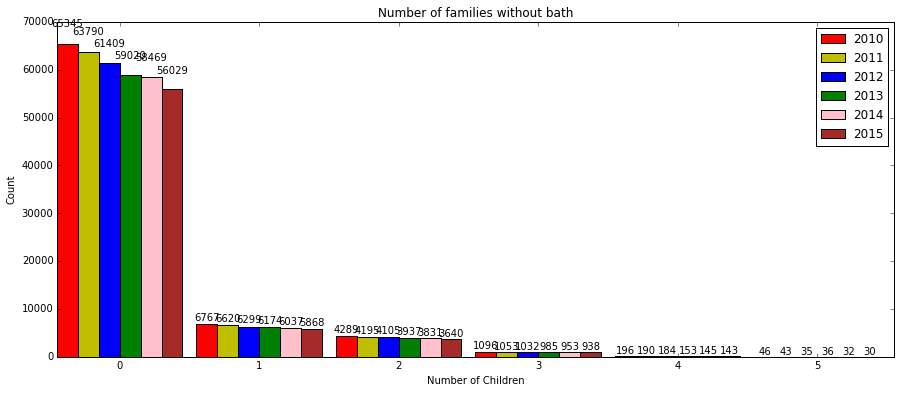

In [3]:
# PLOT WITH NUMBER OF houses without bath for hvert år
year2015bath = {}
year2014bath = {}
year2013bath = {}
year2012bath = {}
year2011bath = {}
year2010bath = {}

for occu in socStatus:
    if occu["BATH"]!="Bathroom in dwelling" and occu["AREA CODE"] != "":
        if occu["YEAR"] == "2015":
            if occu["CHILDREN"] not in year2015bath: 
                year2015bath[occu["CHILDREN"]] = occu["COUNT"]
            else:
                year2015bath[occu["CHILDREN"]] += occu["COUNT"]
        elif occu["YEAR"] == "2014":
            if occu["CHILDREN"] not in year2014bath: 
                year2014bath[occu["CHILDREN"]] = occu["COUNT"]
            else:
                year2014bath[occu["CHILDREN"]] += occu["COUNT"]
        elif occu["YEAR"] == "2013":
            if occu["CHILDREN"] not in year2013bath: 
                year2013bath[occu["CHILDREN"]] = occu["COUNT"]
            else:
                year2013bath[occu["CHILDREN"]] += occu["COUNT"]
        elif occu["YEAR"] == "2012":
            if occu["CHILDREN"] not in year2012bath: 
                year2012bath[occu["CHILDREN"]] = occu["COUNT"]
            else:
                year2012bath[occu["CHILDREN"]] += occu["COUNT"]
        elif occu["YEAR"] == "2011":
            if occu["CHILDREN"] not in year2011bath: 
                year2011bath[occu["CHILDREN"]] = occu["COUNT"]
            else:
                year2011bath[occu["CHILDREN"]] += occu["COUNT"]
        elif occu["YEAR"] == "2010":
            if occu["CHILDREN"] not in year2010bath: 
                year2010bath[occu["CHILDREN"]] = occu["COUNT"]
            else:
                year2010bath[occu["CHILDREN"]] += occu["COUNT"]

N = 6

ind = np.arange(N)  # the x locations for the groups
width = 0.15       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, [year2010bath[i] for i in year2010bath.keys()], width, color='r')
rects2 = ax.bar(ind + 1*width, [year2011bath[i] for i in year2011bath.keys()], width, color='y')
rects3 = ax.bar(ind + 2*width, [year2012bath[i] for i in year2012bath.keys()], width, color='b')
rects4 = ax.bar(ind + 3*width, [year2013bath[i] for i in year2013bath.keys()], width, color='g')
rects5 = ax.bar(ind + 4*width, [year2014bath[i] for i in year2014bath.keys()], width, color='pink')
rects6 = ax.bar(ind + 5*width, [year2015bath[i] for i in year2015bath.keys()], width, color='brown')

# add some text for labels, title and axes ticks
ax.set_ylabel('Count')
ax.set_title('Number of families without bath')
ax.set_xticks(ind + width*3)
ax.set_xlabel("Number of Children")
ax.set_xticklabels(('0', '1', '2', '3', '4','5'))

ax.legend((rects1[0], rects2[0],rects3[0],rects4[0],rects5[0],rects6[0]), ('2010', '2011', '2012', '2013', '2014','2015'))

fig.set_size_inches(15,6)
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)

plt.show()

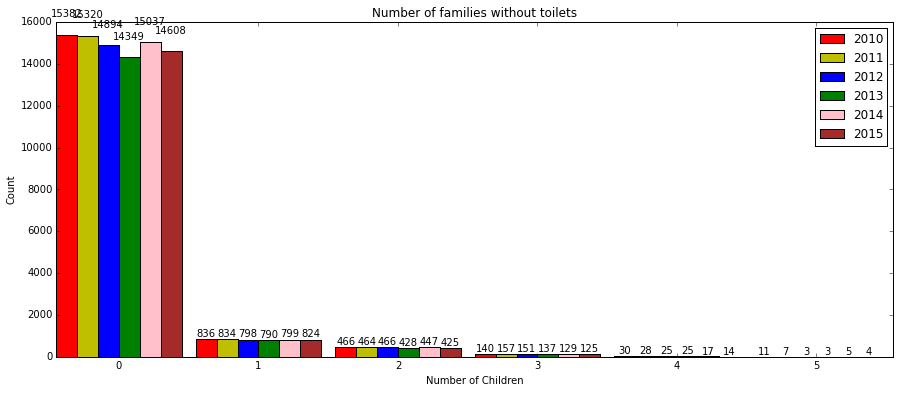

In [4]:
# PLOT WITH NUMBER OF houses without toilet for hvert år
year2015toi = {}
year2014toi = {}
year2013toi = {}
year2012toi = {}
year2011toi = {}
year2010toi = {}

for occu in socStatus:
    if occu["WC"]!="Toilet in dwelling" and occu["AREA CODE"] != "":
        if occu["YEAR"] == "2015":
            if occu["CHILDREN"] not in year2015toi: 
                year2015toi[occu["CHILDREN"]] = occu["COUNT"]
            else:
                year2015toi[occu["CHILDREN"]] += occu["COUNT"]
        elif occu["YEAR"] == "2014":
            if occu["CHILDREN"] not in year2014toi: 
                year2014toi[occu["CHILDREN"]] = occu["COUNT"]
            else:
                year2014toi[occu["CHILDREN"]] += occu["COUNT"]
        elif occu["YEAR"] == "2013":
            if occu["CHILDREN"] not in year2013toi: 
                year2013toi[occu["CHILDREN"]] = occu["COUNT"]
            else:
                year2013toi[occu["CHILDREN"]] += occu["COUNT"]
        elif occu["YEAR"] == "2012":
            if occu["CHILDREN"] not in year2012toi: 
                year2012toi[occu["CHILDREN"]] = occu["COUNT"]
            else:
                year2012toi[occu["CHILDREN"]] += occu["COUNT"]
        elif occu["YEAR"] == "2011":
            if occu["CHILDREN"] not in year2011toi: 
                year2011toi[occu["CHILDREN"]] = occu["COUNT"]
            else:
                year2011toi[occu["CHILDREN"]] += occu["COUNT"]
        elif occu["YEAR"] == "2010":
            if occu["CHILDREN"] not in year2010toi: 
                year2010toi[occu["CHILDREN"]] = occu["COUNT"]
            else:
                year2010toi[occu["CHILDREN"]] += occu["COUNT"]

N = 6

ind = np.arange(N)  # the x locations for the groups
width = 0.15       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, [year2010toi[i] for i in year2010toi.keys()], width, color='r')
rects2 = ax.bar(ind + 1*width, [year2011toi[i] for i in year2011toi.keys()], width, color='y')
rects3 = ax.bar(ind + 2*width, [year2012toi[i] for i in year2012toi.keys()], width, color='b')
rects4 = ax.bar(ind + 3*width, [year2013toi[i] for i in year2013toi.keys()], width, color='g')
rects5 = ax.bar(ind + 4*width, [year2014toi[i] for i in year2014toi.keys()], width, color='pink')
rects6 = ax.bar(ind + 5*width, [year2015toi[i] for i in year2015toi.keys()], width, color='brown')

# add some text for labels, title and axes ticks
ax.set_ylabel('Count')
ax.set_title('Number of families without toilets')
ax.set_xticks(ind + width*3)
ax.set_xlabel("Number of Children")
ax.set_xticklabels(('0', '1', '2', '3', '4','5'))

ax.legend((rects1[0], rects2[0],rects3[0],rects4[0],rects5[0],rects6[0]), ('2010', '2011', '2012', '2013', '2014','2015'))

fig.set_size_inches(15,6)
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)

plt.show()

From the graph with number of families without bath, it is easy to see that the majority of families without bath have zero children, but the overall number of families are getting lower each year, which means that the living standards are improving. 
If we look at the graph with number of families without toilets, it is again the families without children that is the majority, but the number of overall families are lower in 2015 than in 2010, but in 2013 it was even lower than in 2015.
By looking at both graphs there are a lot more families that dont have bathrooms than toilets, which means that people usually chose to have a toilet from a bathroom.

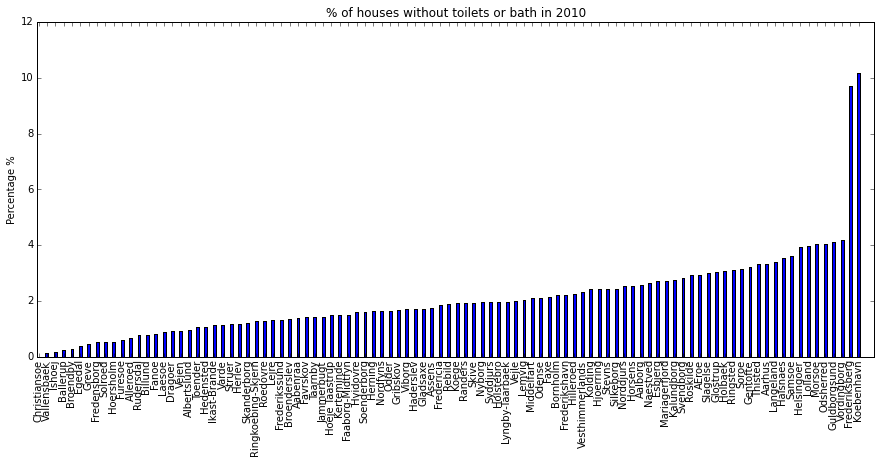

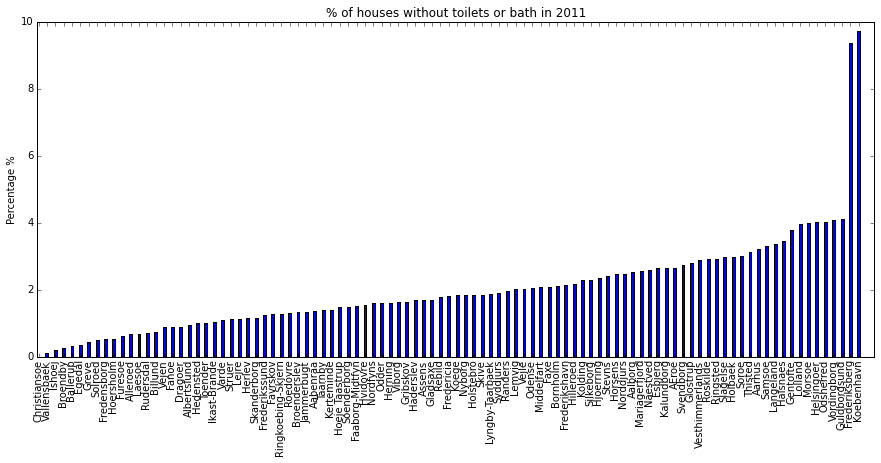

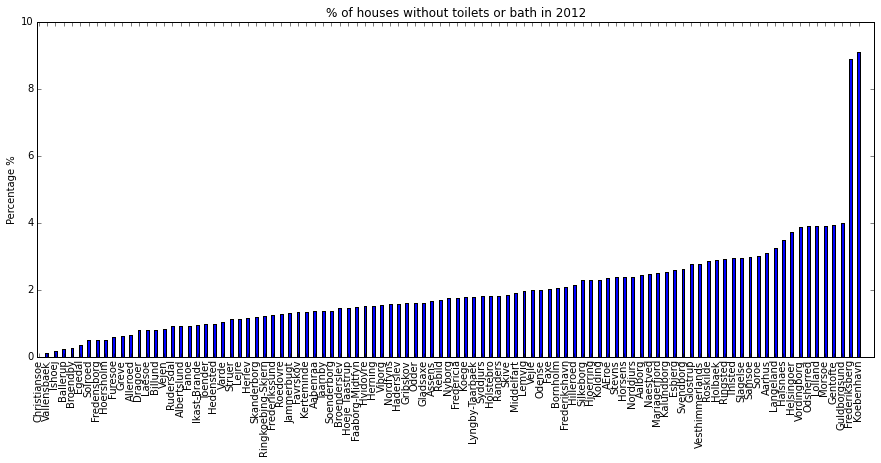

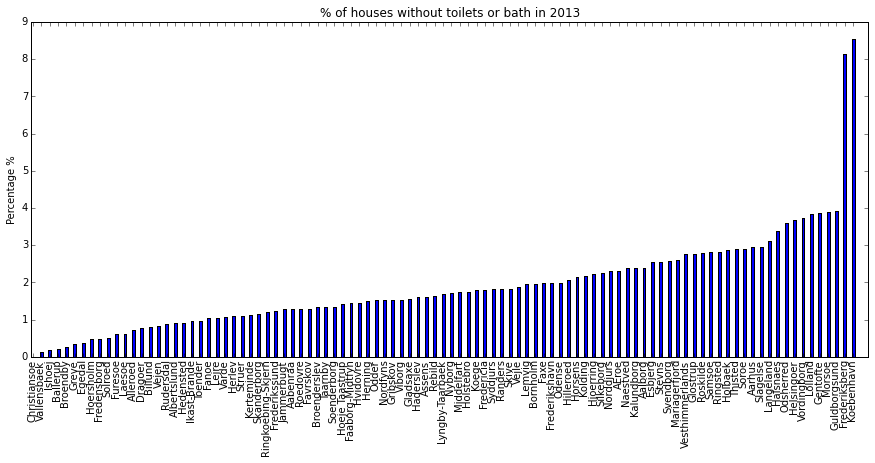

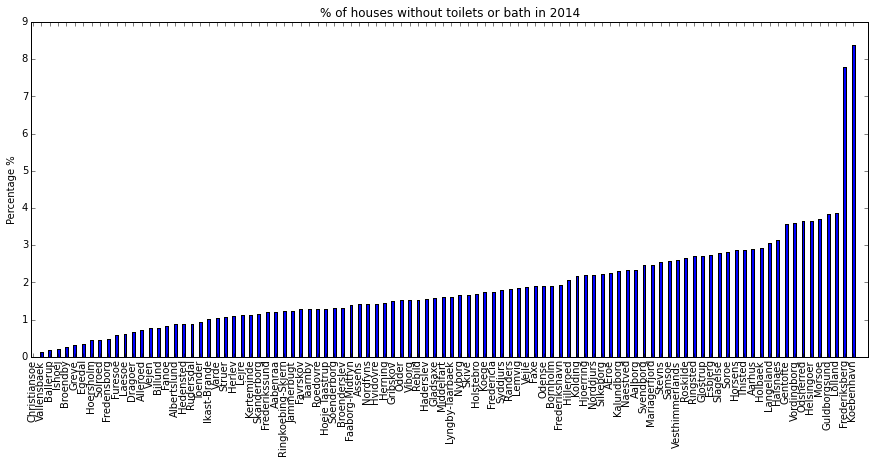

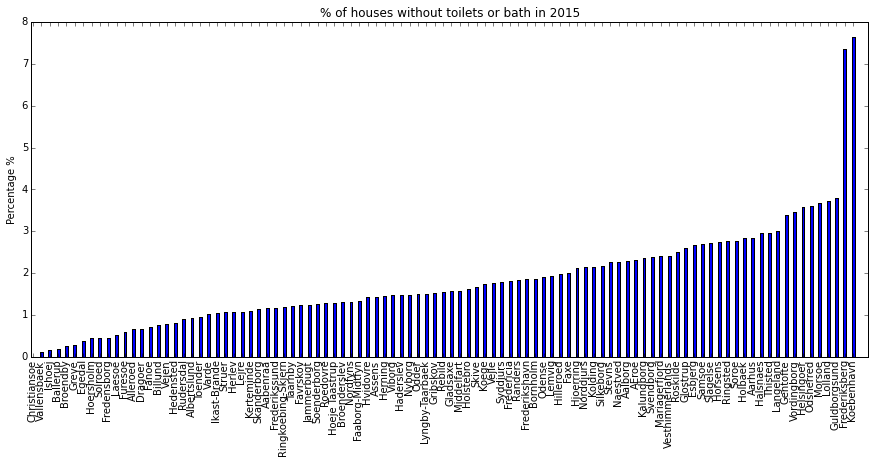

In [5]:
# PLOT WITH AREA with number of no toilet or bath for hvert år
year2015area = {}
year2014area = {}
year2013area = {}
year2012area = {}
year2011area = {}
year2010area = {}

for occu in socStatus:
    if (occu["WC"]!="Toilet in dwelling" or occu["BATH"]!="Bathroom in dwelling")  and occu["AREA CODE"] != "":
        if occu["YEAR"] == "2015":
            if occu["AREA"] not in year2015area:
                year2015area[occu["AREA"]] = occu["COUNT"]
            else:
                year2015area[occu["AREA"]] += occu["COUNT"]
        if occu["YEAR"] == "2014":
            if occu["AREA"] not in year2014area:
                year2014area[occu["AREA"]] = occu["COUNT"]
            else:
                year2014area[occu["AREA"]] += occu["COUNT"]
        if occu["YEAR"] == "2013":
            if occu["AREA"] not in year2013area:
                year2013area[occu["AREA"]] = occu["COUNT"]
            else:
                year2013area[occu["AREA"]] += occu["COUNT"]
        if occu["YEAR"] == "2012":
            if occu["AREA"] not in year2012area:
                year2012area[occu["AREA"]] = occu["COUNT"]
            else:
                year2012area[occu["AREA"]] += occu["COUNT"]
        if occu["YEAR"] == "2011":
            if occu["AREA"] not in year2011area:
                year2011area[occu["AREA"]] = occu["COUNT"]
            else:
                year2011area[occu["AREA"]] += occu["COUNT"]
        if occu["YEAR"] == "2010":
            if occu["AREA"] not in year2010area:
                year2010area[occu["AREA"]] = occu["COUNT"]
            else:
                year2010area[occu["AREA"]] += occu["COUNT"]
numbOfFam2010={}
numbOfFam2011={}
numbOfFam2012={}
numbOfFam2013={}
numbOfFam2014={}
numbOfFam2015={}
for occu in socStatus:
    if occu["AREA CODE"] != "":
        if occu["YEAR"] == "2010":
            if occu["AREA"] not in numbOfFam2010:
                numbOfFam2010[occu["AREA"]] = occu["COUNT"]
            else:
                numbOfFam2010[occu["AREA"]] += occu["COUNT"]
        if occu["YEAR"] == "2011":
            if occu["AREA"] not in numbOfFam2011:
                numbOfFam2011[occu["AREA"]] = occu["COUNT"]
            else:
                numbOfFam2011[occu["AREA"]] += occu["COUNT"]
        if occu["YEAR"] == "2012":
            if occu["AREA"] not in numbOfFam2012:
                numbOfFam2012[occu["AREA"]] = occu["COUNT"]
            else:
                numbOfFam2012[occu["AREA"]] += occu["COUNT"]
        if occu["YEAR"] == "2013":
            if occu["AREA"] not in numbOfFam2013:
                numbOfFam2013[occu["AREA"]] = occu["COUNT"]
            else:
                numbOfFam2013[occu["AREA"]] += occu["COUNT"]
        if occu["YEAR"] == "2014":
            if occu["AREA"] not in numbOfFam2014:
                numbOfFam2014[occu["AREA"]] = occu["COUNT"]
            else:
                numbOfFam2014[occu["AREA"]] += occu["COUNT"]
        if occu["YEAR"] == "2015":
            if occu["AREA"] not in numbOfFam2015:
                numbOfFam2015[occu["AREA"]] = occu["COUNT"]
            else:
                numbOfFam2015[occu["AREA"]] += occu["COUNT"]
                
for i in year2010area.keys():
    if numbOfFam2010[str(i)]!=0:
        year2010area[i] = year2010area[str(i)]/numbOfFam2010[str(i)]*100
for i in year2011area.keys():
    if numbOfFam2011[str(i)]!=0:
        year2011area[i] = year2011area[str(i)]/numbOfFam2011[str(i)]*100
for i in year2012area.keys():
    if numbOfFam2012[str(i)]!=0:
        year2012area[i] = year2012area[str(i)]/numbOfFam2012[str(i)]*100
for i in year2013area.keys():
    if numbOfFam2013[str(i)]!=0:
        year2013area[i] = year2013area[str(i)]/numbOfFam2013[str(i)]*100
for i in year2014area.keys():
    if numbOfFam2014[str(i)]!=0:
        year2014area[i] = year2014area[str(i)]/numbOfFam2014[str(i)]*100
for i in year2015area.keys():
    if numbOfFam2015[str(i)]!=0:
        year2015area[i] = year2015area[str(i)]/numbOfFam2015[str(i)]*100
                
count =0
for data in [year2010area,year2011area,year2012area,year2013area,year2014area,year2015area]:
    width = 0.35       # the width of the bars
    labels, values = zip(*reversed(Counter(data).most_common()))
    fig = plt.figure(figsize=(15, 6))
    plt.bar(range(0,len(data.keys())),values, width, color='b')
    plt.ylabel('Percentage %')
    plt.title('% of houses without toilets or bath in 201'+str(count))
    indexes = np.arange(len(data.keys()))
    plt.xticks(indexes + width * 0.5, [stringClean(key) for key in labels], rotation='vertical')
    plt.show()
    count+=1

Seen from the graphs with percentage of houses without toilets or bath through the years, Copenhagen and Frederiksberg are the places with the highest number. It is also possible to see that both places have improved through the years, but are still more than double as high as the area in number 3. This also makes sense since both Copenhagen and Frederiksberg both have a high population within a smaller area with a lot of apartments.
If we look at the areas with the lowest percentage Vallensbæk, Ishøj and Ballerup they all are quite close to 0, with Vallensbæk being the lowest through the year.

In [6]:
###########
# Features
# And 
# Data Setup
###########

def Features(data):
    feature = []
    feature.append(float(data["HOUSE TYPE"]))
    feature.append(float(data["AREA CODE"].encode('utf-8')))
    feature.append(float(data["YEAR"]))
    feature.append(float(data["WCBATH"]))
    return [feature,float(data["CHILDREN"])]

DT = []
GNB = []
ones = []
for i in range(0,10):

    features = []
    random.shuffle(socStatus)
    for row in socStatus:
        bufFeature=[]
        if row["YEAR"] not in ["2010","2011","2012","2016"] and row["AREA CODE"] != "" and row["CHILDREN"] !=0:
            bufFeature = Features(row)
            for numb in range(0,row["COUNT"]):
                    features.append(bufFeature)
    features = np.array(features)
    random.shuffle(features)
    
    # split the data into 90% traning and 10% test prediction
    featuresX_train = []
    featuresY_train = []
    featuresX_test = []
    featuresY_test = []
    count = 0
    for row in features:
        if count <len(features)*0.9:
            featuresX_train.append(row[0])
            featuresY_train.append(row[1])
        else:
            featuresX_test.append(row[0])
            featuresY_test.append(row[1])
        count+=1

    #################
    # Decision tree
    #################

    # setup the classifiers
    DTClassifier = 0
    DTClassifier = tree.DecisionTreeClassifier(max_depth = 5)
    
    # Train the classifiers and get perdictions from the test data
    DTClassifier.fit(featuresX_train, featuresY_train)
    DTC_predict = DTClassifier.predict(featuresX_test)
    DT.append((featuresY_test == DTC_predict).sum())

    #########################
    # Naive Bayes Classifier
    #########################

    # setup the classifiers
    GNBClassifier = 0
    GNBClassifier = GaussianNB()

    # # Train the classifiers and get perdictions from the test data
    GNBClassifier.fit(featuresX_train, featuresY_train)
    GNB_predict = GNBClassifier.predict(featuresX_test)
    GNB.append((featuresY_test == GNB_predict).sum())

    ones.append((featuresY_test == np.ones(len(featuresY_test))).sum())
    
print "Decision tree classifier"
print DT
print("Number of mislabeled points out of a total %d points : %d"
      % (len(featuresY_test),(featuresY_test != DTC_predict).sum()))
print "Got " + str("{:3.2f}".format(np.mean(DT)/len(featuresY_test)*100))+" % Correct"

print "Naive Bayes classifier"
print GNB
print("Number of mislabeled points out of a total %d points : %d"
      % (len(featuresY_test),(featuresY_test != GNB_predict).sum()))
print "Got " + str("{:3.2f}".format(np.mean(GNB)/len(featuresY_test)*100))+" % Correct"

print "Guessing one every time"
print ones
print "Got " + str("{:3.2f}".format(np.mean(ones)/len(featuresY_test)*100))+" % Correct"

Decision tree classifier
[105459, 107442, 108795, 104189, 109127, 101714, 111322, 103396, 100542, 106352]
Number of mislabeled points out of a total 228284 points : 121932
Got 46.36 % Correct
Naive Bayes classifier
[109223, 109694, 109707, 98149, 111840, 108562, 109987, 104851, 105178, 105091]
Number of mislabeled points out of a total 228284 points : 123193
Got 46.97 % Correct
Guessing one every time
[95181, 93943, 94670, 93374, 96285, 97240, 94824, 93922, 94207, 93546]
Got 41.49 % Correct


## Theory
##### From the Decision tree and Naive Bayes Classifier, we train two models and try to predict our test set. The features made are randomed so that the classifiers aret trained on the same data, we run each classifier ten times. This also means that the predictions wont the be the same, this is the data when we last ran it:

#### Decision tree classifier
[106462, 101035, 101464, 105698, 106493, 107963, 105756, 101621, 105121, 100169]

Number of mislabeled points out of a total 228284 points : 128115

Got 45.64 % Correct
#### Naive Bayes classifier
[109920, 108702, 109511, 109138, 110745, 103957, 109650, 110381, 109928, 98124]

Number of mislabeled points out of a total 228284 points : 130160

Got 47.31 % Correct
#### Guessing one every time
[93311, 93524, 95251, 95252, 94181, 91955, 94323, 94552, 94889, 95231]

Got 41.28 % Correct

##### This means that the Decision tree and the Naive Bayes classifiers are better than guessing the most commen value, but have still guessed less than half correct. 

# Discussion.
## What went well?  What could be improved?
The things that went well with the visualization, is that it runs relatively smooth and is conveying the message on the numbers in a good way. Furthermore the visualization was easy to make due to, a structure being set before going into the work of making the actual visualization. The biggest difficulty that did not get resolved properly is the file sizing , both the GEO data and the loaded files of data are too big. This is also the reason for implementing the loading bar, so a visitor of the site can see that it is loading and not just hanging. For further development of the visualization, the main focus would be to minimize the files and really optimize it.


After we have made our classifiers we can see that the data is not made for classifying. With both classifiers being lower than 50 % they are not optimal for further use, even though they are better than choosing the value with the representive.

# Visualizations
We have chosen to present the data through, an interactive graph with the main numbers for the whole country, this is done because it gives a good overview over the numbers and explains the basics.
We have then made some interactive diagrams, where the main data is done with circles. This is done so the user easily can get an overview of the main points of the dataset and see the relation through the size and keywords and metrics shown at either side of the circle.
For showing the main categories of the dataset, there is a last interactive button that divides the data into the four main categories. Again keeping the circles, this is done so the user easy can see the difference in sizes of the different numbers. But the grouping also gives great visual clues about the actual grouping so the different groups easily can be seen.
For the rest of the data it is shown, in classic graph with some explanatory text, for the people who want to know more about how and why the data comes to live. This also shows the user some of the fun facts about the data.

# Appendix

In [ ]:
################################
# Output file for Decision tree
################################
from sklearn.externals.six import StringIO
with open("Denmark.dot", 'w') as f:
    f = tree.export_graphviz(DTClassifier, out_file=f)

In [8]:
timeNow = time.time()
dataSetOne = []
dataSetTwo = []
for data in socStatus:
    if data["YEAR"] not in ["2010","2011","2012","2016"] and data["AREA CODE"] != "":
            dataSetOne.append({"Year": data["YEAR"],"District Code": data["AREA CODE"],
                               "House type": data["HOUSE TYPE"],"WcBath": data["WCBATH"],
                               "Children": data["CHILDREN"],"Count": data["COUNT"]})

print "It took "+str(time.time()-timeNow)+" seconds to go through "+str(len(dataSetOne))
timeNow=time.time()

for data in cityStatus:
    if data["YEAR"] not in ["2010","2011","2012","2016"] and data["AREA CODE"] != "":
            dataSetTwo.append({"Year": data["YEAR"],"District Code": data["AREA CODE"],
                               "District": data["AREA"],"Count": data["COUNT"]})
            
print "It took "+str(time.time()-timeNow)+" seconds to go through "+str(len(dataSetTwo))

It took 0.169999837875 seconds to go through 48114
It took 0.00100016593933 seconds to go through 297


In [9]:
print dataSetOne[0]
print dataSetTwo[6]

with open("IkkeOpdelt.json", 'w') as outfile:
        json.dump(dataSetTwo, outfile)
with open("Opdelt.json", 'w') as outfile:
        json.dump(dataSetOne, outfile)
print "done"

{'Count': 40, 'House type': '2', 'District Code': u'0440', 'Year': '2013', 'WcBath': '1', 'Children': 3}
{'Count': 5875, 'District Code': u'0155', 'District': 'Drag\xc3\xb8r', 'Year': '2013'}
done


In [10]:
numbOfChildren2010=0
count2010=0
numbOfChildren2011=0
count2011=0
numbOfChildren2012=0
count2012=0
numbOfChildren2013=0
count2013=0
numbOfChildren2014=0
count2014=0
numbOfChildren2015=0
count2015=0

for i in socStatus:
    if i["AREA CODE"] !="":
        if i["YEAR"]=="2010":
            numbOfChildren2010+=float(i["CHILDREN"])*float(i["COUNT"])
            if i["WCBATH"] in ["3","4"]:
                count2010+=float(i["CHILDREN"])*float(i["COUNT"])
        if i["YEAR"]=="2011":
            numbOfChildren2011+=float(i["CHILDREN"])*float(i["COUNT"])
            if i["WCBATH"] in ["3","4"]:
                count2011+=float(i["CHILDREN"])*float(i["COUNT"])
        if i["YEAR"]=="2012":
            numbOfChildren2012+=float(i["CHILDREN"])*float(i["COUNT"])
            if i["WCBATH"] in ["3","4"]:
                count2012+=float(i["CHILDREN"])*float(i["COUNT"])
        if i["YEAR"]=="2013":
            numbOfChildren2013+=float(i["CHILDREN"])*float(i["COUNT"])
            if i["WCBATH"] in ["3","4"]:
                count2013+=float(i["CHILDREN"])*float(i["COUNT"])
        if i["YEAR"]=="2014":
            numbOfChildren2014+=float(i["CHILDREN"])*float(i["COUNT"])
            if i["WCBATH"] in ["3","4"]:
                count2014+=float(i["CHILDREN"])*float(i["COUNT"])
        if i["YEAR"]=="2015":
            numbOfChildren2015+=float(i["CHILDREN"])*float(i["COUNT"])
            if i["WCBATH"] in ["3","4"]:
                count2015+=float(i["CHILDREN"])*float(i["COUNT"])

print "Number of children in 2010: "+ str(numbOfChildren2010)
print "Number of children in 2010 in group 3 and 4: "+ str(count2010)
print "Percentage: "+str(count2010/numbOfChildren2010*100)
print "Number of children in 2011: "+ str(numbOfChildren2011)
print "Number of children in 2011 in group 3 and 4: "+ str(count2011)
print "Percentage: "+str(count2011/numbOfChildren2011*100)
print "Number of children in 2012: "+ str(numbOfChildren2012)
print "Number of children in 2012 in group 3 and 4: "+ str(count2012)
print "Percentage: "+str(count2012/numbOfChildren2012*100)
print "Number of children in 2013: "+ str(numbOfChildren2013)
print "Number of children in 2013 in group 3 and 4: "+ str(count2013)
print "Percentage: "+str(count2013/numbOfChildren2013*100)
print "Number of children in 2014: "+ str(numbOfChildren2014)
print "Number of children in 2014 in group 3 and 4: "+ str(count2014)
print "Percentage: "+str(count2014/numbOfChildren2014*100)
print "Number of children in 2015: "+ str(numbOfChildren2015)
print "Number of children in 2015 in group 3 and 4: "+ str(count2015)
print "Percentage: "+str(count2015/numbOfChildren2015*100)

Number of children in 2010: 1355131.0
Number of children in 2010 in group 3 and 4: 2027.0
Percentage: 0.149579634736
Number of children in 2011: 1361632.0
Number of children in 2011 in group 3 and 4: 2055.0
Percentage: 0.150921834975
Number of children in 2012: 1359964.0
Number of children in 2012 in group 3 and 4: 1991.0
Percentage: 0.146400934142
Number of children in 2013: 1359481.0
Number of children in 2013 in group 3 and 4: 1881.0
Percentage: 0.138361624767
Number of children in 2014: 1355580.0
Number of children in 2014 in group 3 and 4: 1877.0
Percentage: 0.13846471621
Number of children in 2015: 1355254.0
Number of children in 2015 in group 3 and 4: 1843.0
Percentage: 0.135989268432
